In [1]:
import numpy as np
import scipy.io 
import theano.tensor as T
import lasagne
import string
import theano
import BatchNormLayer
import matplotlib.pylab as plt
batch_norm = BatchNormLayer.batch_norm

Using gpu device 2: GeForce GTX TITAN Black (CNMeM is disabled, CuDNN 3007)
/home/zli/2016/ntm-lasagne/src/theano/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [2]:
############# TrainData and TestData Preparation #############

# trainx: 780*50*6 
# trainy: 780*52 or 780
# mask_train: 780*50
loaddata = scipy.io.loadmat('../dataset/Data2.mat')
traindata = loaddata['TrainData']
testdata = loaddata['TestData']

trainx = []
trainy = []

for i in xrange(traindata.shape[0]):
	for j in xrange(traindata.shape[1]):
		trainx.append(traindata[i][j])
		trainy.append(i)

trainx = np.asarray(trainx)
trainy = np.asarray(trainy)
mask_train = np.ones([trainx.shape[0], trainx.shape[1]])
#print trainy.shape
#print trainy

# testx: 624*20*6
# testy: 624*52 or 624
# mask_test: 624*20
testx = []
testy = []

for i in xrange(testdata.shape[0]):
	for j in xrange(testdata.shape[1]):
		testx.append(testdata[i][j])
		testy.append(i)

testx = np.asarray(testx)
testy = np.asarray(testy)
mask_test = np.ones([testx.shape[0], testx.shape[1]])
#print testy.shape
#print testy

In [3]:
##########  Initialize Parameters ########
N_BATCH = 52
MAX_LENGTH = trainx.shape[1]
features_num = 6
GRAD_CLIP = 100
TOL = 1e-5
LEARNING_RATE = 1e-2
N_HIDDEN = 120
num_epochs = 300

##########  Build Model for Prediction #######################
mask = np.ones([N_BATCH, MAX_LENGTH])
target_values = T.ivector('target_output')
sym_mask = T.matrix('mask')

print("Building network ...")

l_in = lasagne.layers.InputLayer(shape=(N_BATCH, MAX_LENGTH, features_num))
#l_mask = lasagne.layers.InputLayer(shape=(N_BATCH, MAX_LENGTH))
#### Bidirectional RNN layers ###
l_forward = lasagne.layers.GRULayer(
        l_in, N_HIDDEN, grad_clipping=GRAD_CLIP, only_return_final=True)
        #W_in_to_hid=lasagne.init.HeUniform(),
        #W_hid_to_hid=lasagne.init.HeUniform(),
        #nonlinearity=lasagne.nonlinearities.tanh, only_return_final=True)

l_backward = lasagne.layers.GRULayer(
        l_in, N_HIDDEN, grad_clipping=GRAD_CLIP, only_return_final=True, backwards=True)
        #W_in_to_hid=lasagne.init.HeUniform(),
        #W_hid_to_hid=lasagne.init.HeUniform(),
        #nonlinearity=lasagne.nonlinearities.tanh,
        #only_return_final=True, backwards=True)


l_concat = lasagne.layers.ConcatLayer([l_forward, l_backward])
l_concat = batch_norm(l_concat)

###  Softmax for prediction output ######
l_fc1 = lasagne.layers.DenseLayer(
	    lasagne.layers.dropout(l_concat, p=.5),
        num_units=100, nonlinearity=lasagne.nonlinearities.rectify)
l_fc1 = batch_norm(l_fc1)

l_out = lasagne.layers.DenseLayer(
	    lasagne.layers.dropout(l_fc1, p=.5),
        num_units=52, nonlinearity=lasagne.nonlinearities.softmax)

Building network ...


In [4]:
########### Debug ###########
all_layers = lasagne.layers.get_all_layers(l_out)
num_params = lasagne.layers.count_params(l_out)
print("  number of parameters: %d" % num_params)
print("  layer output shapes:")
for layer in all_layers:
	name = string.ljust(layer.__class__.__name__, 32)
	print("    %s %s" % (name, lasagne.layers.get_output_shape(layer)))

############## Compile the model, calculate cost, update ######################
#########  #######
network_output = lasagne.layers.get_output(l_out)

out_train = lasagne.layers.get_output(l_out, mask = sym_mask, deterministic=False)

out_test = lasagne.layers.get_output(l_out, mask = sym_mask, deterministic=True)

cost = T.nnet.categorical_crossentropy(T.clip(network_output, TOL, 1-TOL), target_values)
cost = cost.mean()
# Retrieve all parameters from the network
all_params = lasagne.layers.get_all_params(l_out, trainable=True)

all_grads = T.grad(cost, all_params)

updates, norm_calc = lasagne.updates.total_norm_constraint(all_grads, max_norm= 20, return_norm=True)

# Compute SGD updates for training
print("Computing updates ...")
#updates = lasagne.updates.adagrad(cost, all_params, LEARNING_RATE)
updates = lasagne.updates.adam(cost, all_params, LEARNING_RATE)

print("Compiling functions ...")
train = theano.function([l_in.input_var, target_values, sym_mask], \
	                    [cost, out_train], updates=updates, \
	                    on_unused_input='ignore', allow_input_downcast=True)
#compute_cost = theano.function([l_in.input_var, target_values, l_mask.input_var], cost)
test = theano.function([l_in.input_var, target_values, sym_mask], \
                        [cost, out_test], on_unused_input='ignore', allow_input_downcast=True)

  number of parameters: 122292
  layer output shapes:
    InputLayer                       (52, 50, 6)
    GRULayer                         (52, 120)
    GRULayer                         (52, 120)
    ConcatLayer                      (52, 240)
    BatchNormLayer                   (52, 240)
    DropoutLayer                     (52, 240)
    DenseLayer                       (52, 100)
    BatchNormLayer                   (52, 100)
    NonlinearityLayer                (52, 100)
    DropoutLayer                     (52, 100)
    DenseLayer                       (52, 52)
Computing updates ...
Compiling functions ...


In [5]:
print("Training ...")
seq_names = np.arange(0, trainx.shape[0])
np.random.shuffle(seq_names)
trainx = trainx[seq_names]
trainy = trainy[seq_names]  
mask_train = mask_train[seq_names]
cost_train = []
out_train = []
EPOCH_SIZE_TRAIN = trainx.shape[0]// N_BATCH
accuracy_train = []

seq_names_test = np.arange(0, testx.shape[0])
np.random.shuffle(seq_names_test)
testx = testx[seq_names_test]
testy = testy[seq_names_test]  
mask_test = mask_test[seq_names_test]
cost_test = []
out_test = []
EPOCH_SIZE_TEST = testx.shape[0]// N_BATCH
accuracy_test = []

for epoch in range(num_epochs):
	### Train part ###
    out_train_epoch = []
    cost_train_epoch = 0
    for i in xrange(EPOCH_SIZE_TRAIN):
    	idx = xrange(i*N_BATCH, (i+1)*N_BATCH)
    	x_batch = trainx[idx]
    	y_batch = trainy[idx]
    	mask_batch = mask_train[idx]

    	cost_train_batch, out_train_batch = train(x_batch, y_batch, mask_batch)
    	out_train_epoch.append(out_train_batch)
    	cost_train_epoch += cost_train_batch

    out_train_epoch = np.asarray(out_train_epoch)
    out_train_epoch = out_train_epoch.reshape(-1, 52)    
    out_train.append(out_train_epoch)
    cost_train.append(cost_train_epoch)
    ### Accuracy calculation ####
    sum = 0
    for i in xrange(out_train_epoch.shape[0]):
    	predict_label = np.argmax(out_train_epoch[i,:])
    	if predict_label == trainy[i]:
    		sum += 1
    accuracytrain = float(sum)/float(out_train_epoch.shape[0])
    accuracy_train.append(accuracytrain)
    print("Epoch {} train cost = {}".format(epoch, cost_train_epoch))
    print("Epoch {} train accuracy = {}".format(epoch, accuracytrain))

    ### Inference Part ###
    out_test_epoch = []
    cost_test_epoch = 0
    for i in range(EPOCH_SIZE_TEST):
		idx = range(i*N_BATCH, (i+1)*N_BATCH)
		x_batch = testx[idx]
		y_batch = testy[idx]
		mask_batch = mask_test[idx]

		cost_test_batch, out_test_batch = test(x_batch, y_batch, mask_batch)
		out_test_epoch.append(out_test_batch)
		cost_test_epoch += cost_test_batch

    out_test_epoch = np.asarray(out_test_epoch)
    out_test_epoch = out_test_epoch.reshape(-1, 52)
    out_test.append(out_test_epoch)
    cost_test.append(cost_test_epoch)
    #print out_test_epoch.shape
    #print out_test_epoch
    ### Accuracy calculation ####
    sum = 0
    for i in xrange(out_test_epoch.shape[0]):
    	predict_label = np.argmax(out_test_epoch[i,:])
    	if predict_label == testy[i]:
    		sum += 1
    accuracytest = float(sum)/float(out_test_epoch.shape[0])
    accuracy_test.append(accuracytest)
    print("Epoch {} test cost = {}".format(epoch, cost_test_epoch))
    print("Epoch {} test accuracy = {}".format(epoch, accuracytest))
    

Training ...
Epoch 0 train cost = 57.2792925835
Epoch 0 train accuracy = 0.0807692307692
Epoch 0 test cost = 37.0496447086
Epoch 0 test accuracy = 0.0592948717949
Epoch 1 train cost = 39.8283603191
Epoch 1 train accuracy = 0.244871794872
Epoch 1 test cost = 28.3403717279
Epoch 1 test accuracy = 0.152243589744
Epoch 2 train cost = 31.3082764149
Epoch 2 train accuracy = 0.378205128205
Epoch 2 test cost = 24.1504733562
Epoch 2 test accuracy = 0.209935897436
Epoch 3 train cost = 25.8168977499
Epoch 3 train accuracy = 0.485897435897
Epoch 3 test cost = 20.4158207178
Epoch 3 test accuracy = 0.363782051282
Epoch 4 train cost = 22.1267129183
Epoch 4 train accuracy = 0.547435897436
Epoch 4 test cost = 18.3605703115
Epoch 4 test accuracy = 0.711538461538
Epoch 5 train cost = 19.7086107731
Epoch 5 train accuracy = 0.547435897436
Epoch 5 test cost = 16.2441641092
Epoch 5 test accuracy = 0.504807692308
Epoch 6 train cost = 18.2172036171
Epoch 6 train accuracy = 0.60641025641
Epoch 6 test cost = 15.

train max 0.991025641026  is at 279 epoch 

test max 0.951923076923  is at 278 epoch 



/home/zli/anaconda/lib/python2.7/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The "loc" positional argument to legend is deprecated. Please use the "loc" keyword instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


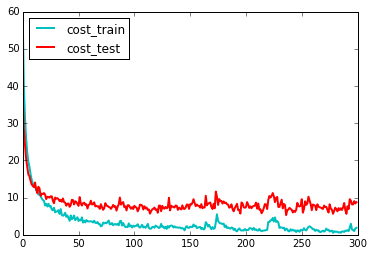

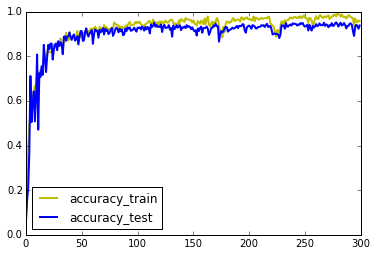

In [6]:
%matplotlib inline
plt.figure(1)
plt.plot(cost_train, 'c', cost_test, 'r', linewidth=2.0)
plt.legend(("cost_train", "cost_test"),'upper left')

plt.figure(2)
plt.plot(accuracy_train, 'y', accuracy_test, 'b', linewidth=2.0)
plt.legend(("accuracy_train", "accuracy_test"),'lower left')

print "train max", np.max(accuracy_train), " is at", np.argmax(accuracy_train), "epoch \n"  
print "test max", np.max(accuracy_test), " is at", np.argmax(accuracy_test), "epoch \n"  
#plt.show()